# Ames: Exploration, Cleaning

At the beginning of this project, as with any data science project, it's essential to do the following:
 - Import libraries that will be leveraged over the course of our notebook
 - Get a feel for the data we are working with
 - Clean our data set and check for abnormalities
 
By the end of this notebook, we will have produced a clean data set to move forward with model fitting and optimization.

 - [Setup](#Reading-In-Our-Data)
 - [Initial Data Exploration](#Initial-Data-Exploration)
 - [Encoding Ordinals](#Encoding-Ordinals)
 - [Dealing with Nulls](#Dealing-with-Nulls)
 - [Building Dummies](#Build-Dummies)

### Relevant Libraries

In [426]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
%matplotlib inline

*****
### Reading In Our Data

The first step we'll take as part of this project is bringing our data into a DataFrame. One small caveat here that needs to be addressed, however. We have been given both a **training.csv** file and and a **test.csv** file as part of this Kaggle competition repository. While there are several ways to manage the data pipeline here, I have chosen to combine these data sets together for the initial stages of data cleansing and exploration.

The reason I have made this determination is because I want to ensure that, come submission time, I have the exact same number of features in my **X** test set with which to predict our final housing prices. Beyond feature consistency, this is also going to give me the chance to address any and all cases of **NaN** values across both files should there be inconsistencies and edge cases that would not be addressed by focusing solely on the **train.csv** file.

I'll start by reading both files into separate data frames...

In [427]:
#Read in both of the files 
houses_train = pd.read_csv('./datasets/train.csv')
houses_test = pd.read_csv('./datasets/test.csv')

Because our **test** data set, here denoted as *'houses_test'*, does not have SalePrice (we will be predicting this later), I'll start by filling the SalePrice column for this data set with zeros to avoid any issues with concatenation later. A quick call to the .shape attribute demonstrates that the columns are now consistent across dataframes.

In [428]:
#Incorporate a SalePrice column into the test df
houses_test['SalePrice'] = 0

In [429]:
#Check df shapes 
houses_train.shape, houses_test.shape

((2051, 81), (879, 81))

I will now concatenate these dataframes together and confirm that the ancitipated shape is consistent with my expectations.

In [430]:
#Bring our dfs together for combined cleaning and null imputation
houses = pd.concat([houses_train, houses_test], axis=0)

In [431]:
#Check final shape
houses.shape

(2930, 81)

****
### Initial Data Exploration

#### First Glance

Now that we have our combined dataframe, we can proceed with initial exploration steps. We'll start by looking at our columns, leverage the .describe() method to get a quick sense for the properties of our numerical columns, before moving forward with a strategy to handle **NaNs**.

In [432]:
#What columns in our data set?
houses.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [433]:
#What columns in our data set?
houses.dtypes.value_counts()

object     42
int64      28
float64    11
dtype: int64

It appears that we are dealing with a mix of different types of features in our dataset. Excluding SalePrice, we have a total of **80 features**, the majority of which are type **object (42)** with the remanining features a mix of **int (28)** and **float (11)**. From the data dictionary, we can break this down further into **nominal, ordinal, discrete, and continous features**. As a brief reminder, let's remind ourselves of what these types of variables represent. Please refer to the README for a full list of what columns are of what type.

- **Nominal**: It does not matter which way the categories are ordered in tabular or graphical displays of the data -- all orderings are equally meaningful. For example, neighborhood is nominal.
- **Ordinal**: A categorical variable whose categories can be meaningfully ordered is called ordinal. For example, Exterior Quality Scores could be considered ordinal
- **Discrete**: A variable whose values are whole numbers (counts) is called discrete. For example, the number of items bought by a customer in a supermarket is discrete.
- **Continous**: A variable that may contain any value within some range is called continuous. For example, the time that the customer spends in the supermarket is continuous.

*Source:* http://www-ist.massey.ac.nz/dstirlin/CAST/CAST/Hstructures/structures_c2.html




In [434]:
#A list of the nominal columns in our dataset for later reference
nominal_cols = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config', 'Neighborhood', 
 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style','Roof Matl', 'Exterior 1st', 'Exterior 2nd', 
 'Mas Vnr Type', 'Exter Qual', 'Foundation', 'Heating', 'Central Air', 'Garage Type', 'Misc Feature', 'Sale Type']

#A list of the ordinal columns in our data set for later reference
ordinal_cols = ['Lot Shape','Utilities','Land Slope','Overall Qual',
 'Overall Cond','Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond',
 'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC',
 'Electrical', 'Kitchen Qual','Functional','Fireplace Qu',
 'Garage Finish','Garage Qual','Garage Cond','Paved Drive',
 'Pool QC','Fence']


In [435]:
#Gather a quick statistical summary of our dataframe. Limiting to 5 rows for visual purposes here
houses.describe().T[['count','mean','std','min','max']].head()

,count,mean,std,min,max
Id,2930.0,1.465500e+03,8.459625e+02,1.0,2.930000e+03
PID,2930.0,7.144645e+08,1.887308e+08,526301100.0,1.007100e+09
MS SubClass,2930.0,5.738737e+01,4.263802e+01,20.0,1.900000e+02
Lot Frontage,2440.0,6.922459e+01,2.336533e+01,21.0,3.130000e+02
Lot Area,2930.0,1.014792e+04,7.880018e+03,1300.0,2.152450e+05


An initial assessment of the dataset through .describe() reveals a few properties we'll need to be wary of moving forward:
 - The counts of several columns are not adding up to the anticipated number of rows of our data set. A quick count of NaN values shows **13997 NaNs** that will need to be addressed.
 - Several minimums reveal interest information. For example, we can see that some **Garage** construction dates go back to the 1800's. Year will be an interesting column for us moving forward as we think about how to incorporate into our model.
 - Some columns, such as **Lot Area**, are showing signiciant spread (you can look at the standard deviation, and range to get a sense here). We'll need to get a better look at the distribution of Square Footage / Area to get a better grasp on the properties of these features.

****
#### Distributions

Finally, it is always advisable to get an understanding of our distributions. We'll take a look at our target, in addition to various features to understand what we're working with.

1.5575514385863427

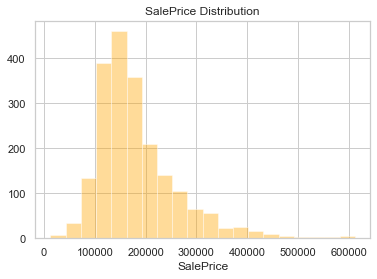

In [436]:
#Split out our SalesPrice data for our training set-- 
#recall the test set is also part of the DF so we need to use iloc to exclude.
sns.distplot(houses.iloc[:2051,80],bins=20, kde=False, color='orange');
plt.title('SalePrice Distribution')
plt.xlabel('SalePrice')
houses.iloc[:2051,80].skew()

Overall the target appears so have a strong positive/right skew. This is important to note because linear regression models assume normal distributions for residuals. We'll make note of this now and transform our target down the line with more advanced techniques. What about our features? One hypothesis we have is that, similar to price, we are also likely dealing with a positive right skew for living area and square footage. In other words, we are dealing with a smaller amount of large homes which may in turn be skewing our pricing data. Let's take a look.

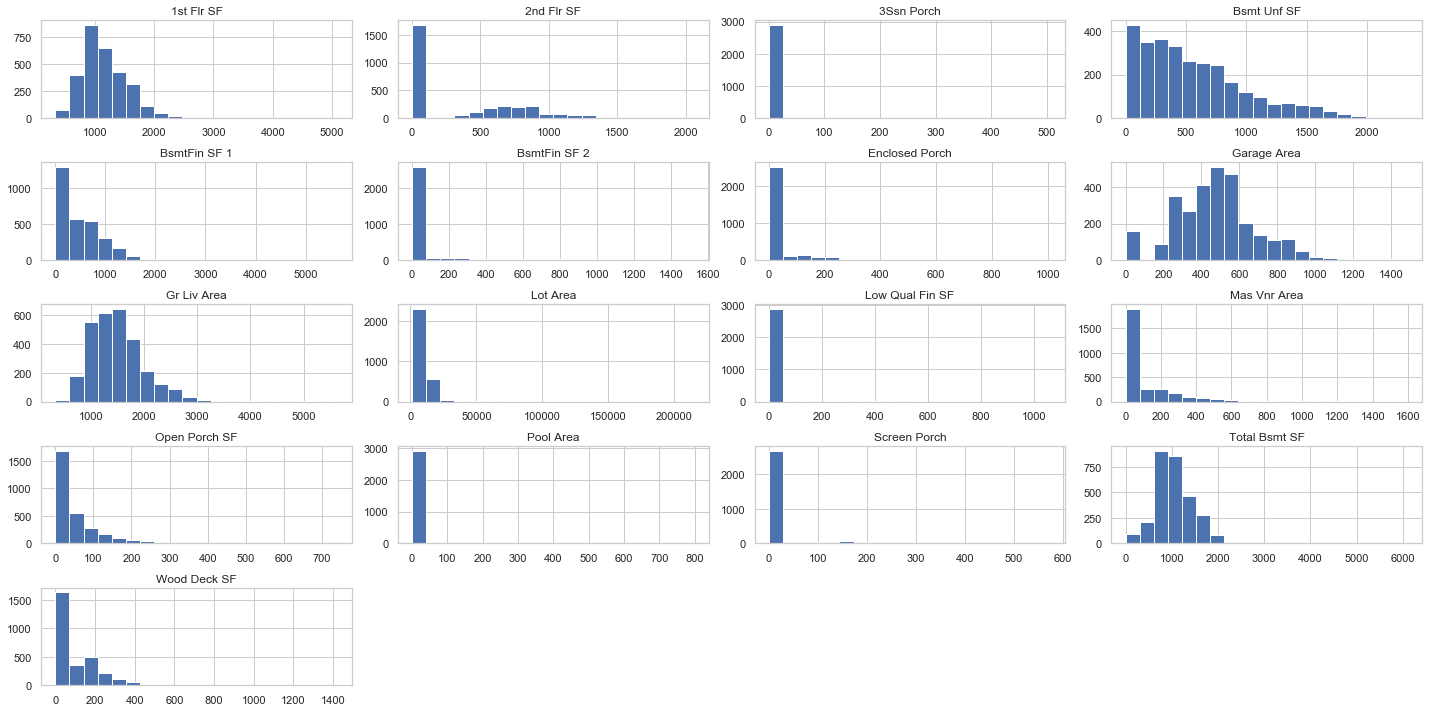

In [437]:
#Grab anything that references square footage, area, or porches and take a look at their distributions
dist_check_list = list(houses.filter(like='SF', axis=1).columns)

#Extend the list to include more than just SF
dist_check_list.extend(list(houses.filter(like='Area', axis=1).columns))
dist_check_list.extend(list(houses.filter(like='Porch', axis=1).columns))

#We have some duplicates in our list. Let's get rid of them so we can pass into a DF to plot
dist_check_list = list(set(dist_check_list))

#Plot out histograms
houses[dist_check_list].hist(figsize=(20,10), bins=20, align='mid');
plt.tight_layout()


It does look like, in a number of cases, we will need to consider transformations for features demonstrating a strong positive skew. More to come here, we'll address this as we being to pull together our training data. Also of note here are the large amounts of zeroes for things like 2nd Flr Sq Footage, and Screen Porches. We'll want to make sure these features are being properly represented in our data. We'll take this step a little later in the process.

#### Categorical BoxPlots

We can also leverage **boxplots** to get a better sense of distributions by categorical values, so let's select som features for deeper exploration. We'll start with what we believe to be an important metric given how all-encompassing it's description is from the data dictionary -- **Overall Qual**. From the chart below, we see that as Overall Qual increases, the sale price also increases. Also of note here is the **curved** nature of this boxplot -- this suggests that the relationship here between Overall Qual and Saleprice is not linear.

Also helpful here are the number of outliers that we see. There are relatively few for lower Quality Score homes (1-3) but we start to see strong variation in the mid-score range. We also see some extreme outliers where Overall Qual is 10, indicating that perhaps these sales were in-family. 

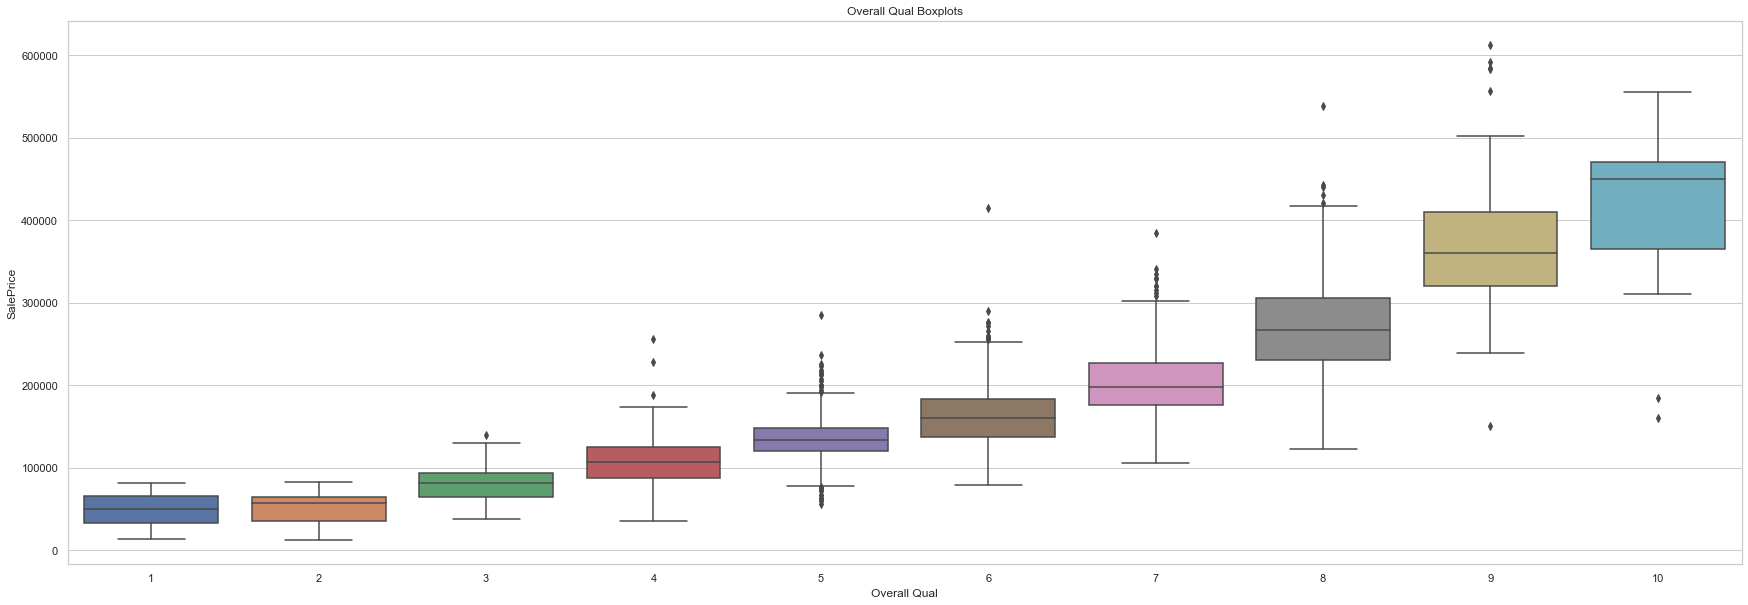

In [438]:
#Boxplots of Overall Qual in terms of Saleprice
plt.figure(figsize=(30,10))
sns.boxplot(x="Overall Qual", y="SalePrice", data=houses.iloc[:2050,:]);
plt.title("Overall Qual Boxplots");

When we look at boxplots of **Exter Qual**, we see a similar pattern. We use the parameter **order** here as these values have not been numerically encoded, and we know that this is a score that is ordered by referencing the Assessor's data dictionary.

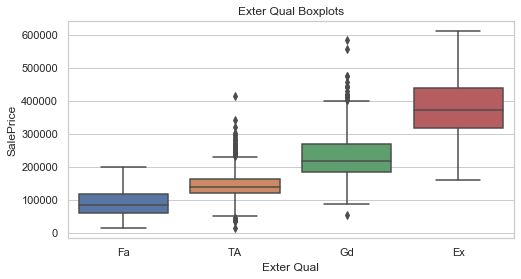

In [439]:
plt.figure(figsize=(8,4))
sns.boxplot(x="Exter Qual", y="SalePrice", data=houses.iloc[:2050,:], order=['Fa','TA','Gd', 'Ex']);
plt.title("Exter Qual Boxplots");

One last check before making any transformations to our data. Using pairplotting, do we see similar curves across any other features? In addition to these features, YearBuilt appears to have a strong upward curved relationship with SalePrice. Basement Half Bath also appears to potentially demonstrate a negative curved relationship. Let's table this for now and dive a little bit deeper into correlations with our target.

In [440]:
#Isolate some of our top correlated features
initial_corr_list = np.abs(houses.iloc[:2050,:].corr()['SalePrice'])

In [441]:
#Build a list of correlations -- let's focus on most correlated by positive/negative correlations
initial_corr_list_plot = initial_corr_list.sort_values(ascending=False).head(15).index

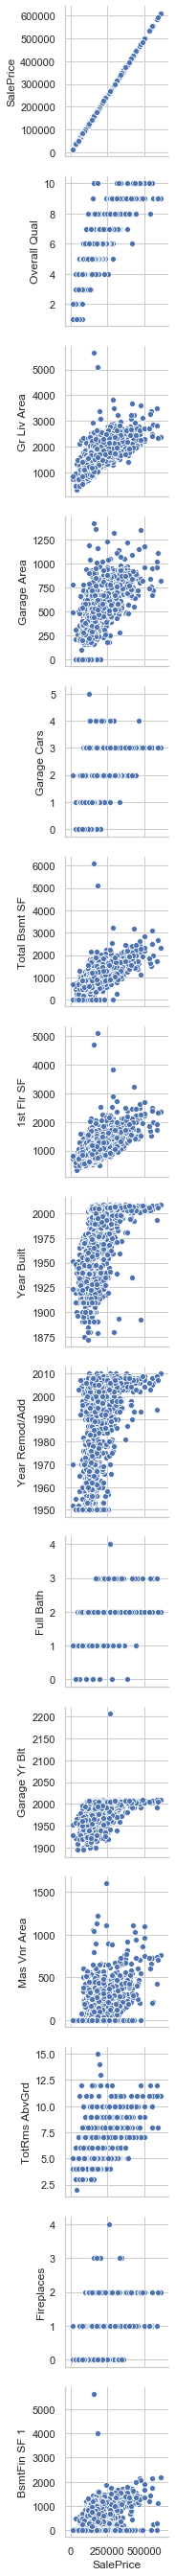

In [442]:
#Pairplot our head and tails lists
sns.pairplot(data=houses.iloc[:2050,:],
                  x_vars=['SalePrice'],
                  y_vars=initial_corr_list_plot);

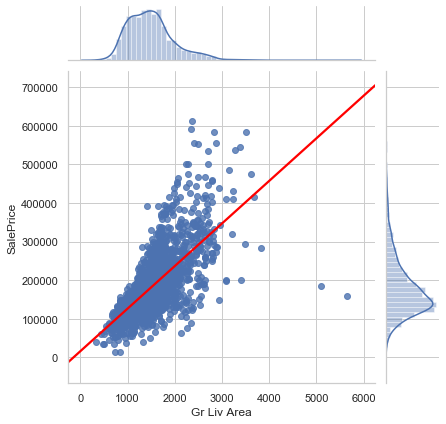

In [443]:
scatter_df = houses.iloc[:2050,:]
# sns.regplot(scatter_df['Gr Liv Area'], scatter_df['SalePrice'], line_kws='red')
sns.jointplot(x='Gr Liv Area', y='SalePrice', data=scatter_df, kind='reg', ci=None,
                  joint_kws={'line_kws':{'color':'red'}});

Text(0.5, 1.0, 'SalePrice Distribution')

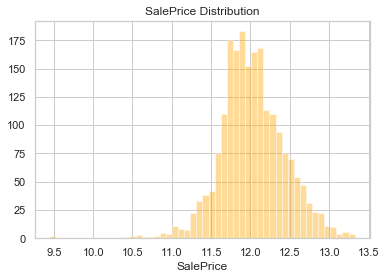

In [444]:
sns.distplot(np.log(houses_scatter['SalePrice']), kde=False, color='orange');
plt.title('SalePrice Distribution')

We see from some of the above pairplots there are some significant outliers (Gr Liv Area, 1st Flr SF, Total Bsmt SF, Low Qual Fin SF being the main culprits. Before moving forward we'll adjust these outliers to bring them inline with the patterns we are seeing.

In [445]:
# #Let's impute some of our outliers for highly correlated features
houses.loc[houses['Gr Liv Area'] > 4000, 'Gr Liv Area'] = houses['Gr Liv Area'].mean()
houses.loc[houses['Low Qual Fin SF'] > 510, 'Low Qual Fin SF'] = houses['Low Qual Fin SF'].mean()
houses.loc[houses['Total Bsmt SF'] > 4000, 'Total Bsmt SF'] = houses['Total Bsmt SF'].mean()
houses.loc[houses['1st Flr SF'] > 3000, '1st Flr SF'] = houses['1st Flr SF'].mean()

## Encoding Ordinals

Overall the target appears so have a strong positive/right skew. This is important to note because linear regression models assume normal distributions. We'll make note of this now and transform our target down the line with more advanced techniques. What about our features? One hypothesis we have is that, similar to price, we are also likely dealing with a positive right skew for living area and square footage. In other words, we are dealing with a smaller amount of large homes which may in turn be skewing our pricing data. Let's take a look.

How are ordinal values stored in our data set? It's important to understand this as we will need to encode these numerically for later processing purposes. It may also be beneficial for us to do this from the outset in case we want to leverage the mean for Ordinal NaN imputation, for example. In addition to referencing our Data Dictionary, let's also look at hose these values are being stored in our DataFrame.

In [446]:
pd.DataFrame(houses['Electrical'].value_counts())

,Electrical
SBrkr,2682
FuseA,188
FuseF,50
FuseP,8
Mix,1


In [447]:
pd.DataFrame(houses['Fence'].value_counts())

,Fence
MnPrv,330
GdPrv,118
GdWo,112
MnWw,12


Features like **'Electrical'** and **'Fence'** all have object-type labels, but by referencing the data dictionary, we know that these values inherently express an order. In the case of **Electrical**, the properties are defined as follows:

|Ordinal Value|Description|
       |SBrkr	|Standard Circuit Breakers & Romex|
       |FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)|
       |FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)|
       |FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)|
       Mix	Mixed|


As you can see, these values communicate varying levels of Electrical utilities. Based on the Assessor's definitions, each label connotes a different value (FuseA is average, Fuse P is Poor), so we know we are dealing with an **ordinal feature**. As such, this is a good candidate for encoding. A close assessement of the data dictionary reveals **23 ordinal features** that will need to be similarly encoded. 

We need to be very careful about how these are encoded, as the numeric relationship between the varying levels of ordinal information by feature will have a significant impact on our model. The Assessor's office did provide **Quality Scores** for several home variables that we can reference. For the remainder of this notebook, we will leverage the Assessors Approach, which is to leverage the value 1 for "Poor" and the highest value for "Excellent" when encoding ordinals.

In [448]:
#Reference an example 
pd.DataFrame(houses['Overall Qual'].value_counts())

,Overall Qual
5,825
6,732
7,602
8,350
4,226
9,107
3,40
10,31
2,13
1,4


With this approach in place, let's look back at our list of ordinal variables. In one sweeping move, we will leverage this encoding approach and translate all of our ordinal columns into numeric values. We also notice that several consistent groupings arise across ordinal features so we will define dictionaries for these values to apply where it makes sense.

In [449]:

#Some ordinals share scales so let's store those here
group_1_ordinals = {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1}
group_2_ordinals = {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1, 'NA' : 0}
group_3_ordinals = {'GLQ' : 6, 'ALQ' : 5, 'BLQ' : 4, 'Rec' : 3, 'LwQ' : 2, 'Unf' : 1, 'NA' : 0}

#Build a dictionary of all the mappings for our ordinal columns
ordinal_dict = {
    'Lot Shape'     : {'Reg' : 4, 'IR1' : 3, 'IR2' : 2, 'IR3' : 1},
    'Utilities'     : {'AllPub' : 4, 'NoSewr' : 3, 'NoSeWa' : 2, 'ELO' : 1},
    'Land Slope'    : {'Gtl' : 3, 'Mod' : 2, 'Sev' : 1},
    'Electrical'    : {'SBrkr': 5, 'FuseA': 4, 'FuseF': 3, 'FuseP': 2 , 'Mix': 1},
    'Kitchen Qual'  : {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po': 1},
    'Functional'    : {'Typ' : 7, 'Min1' : 6, 'Min2' : 5, 'Mod' : 4, 'Maj1' : 3, 'Maj2' : 2, 'Sev' :1},
    'Garage Finish' : {'Fin' : 3, 'RFn' : 2, 'Unf' : 1, 'NA' : 0},
    'Paved Drive'   : {'Y' : 3, 'P' : 2, 'N' : 1},
    'Pool QC'       : {'Ex' : 4, 'Gd' : 3, 'TA' : 2, 'Fa' : 1, 'NA' : 0},
    'Fence'         : {'GdPrv' : 4, 'MnPrv' : 3, 'GdWo' : 2, 'MnWw' : 1 , 'NA' : 0},
    'Bsmt Exposure' : {'Gd' : 4, 'Av' : 3, 'Mn' : 2, 'No' : 1, 'NA' : 0},
    'Exter Qual'    : group_1_ordinals,
    'Exter Cond'    : group_1_ordinals,
    'Heating QC'    : group_1_ordinals,   
    'Bsmt Qual'     : group_2_ordinals,
    'Bsmt Cond'     : group_2_ordinals, 
    'Garage Qual'   : group_2_ordinals, 
    'Garage Cond'   : group_2_ordinals,
    'Fireplace Qu'  : group_2_ordinals,        
    'BsmtFin Type 1': group_3_ordinals,
    'BsmtFin Type 2': group_3_ordinals,
}


#Encode our ordinal columns. There are several cases (Qual Overall) where we'll encounter an error.
#As these are already encoded with int values, we can pass on these conversions.
for ordinal_col in houses[ordinal_cols].columns:
    try:
        houses[ordinal_col] = houses[ordinal_col].map(ordinal_dict[ordinal_col])
    except:
        pass

In [450]:
#Confirm that we see a reduction in type=object features
houses.dtypes.value_counts()

int64      33
float64    27
object     21
dtype: int64

## Dealing with Nulls

We'll now move into null value imputation First, let's visualize nulls by columns, and build a list of columns that contain any nulls at all so we can reference as we clean.

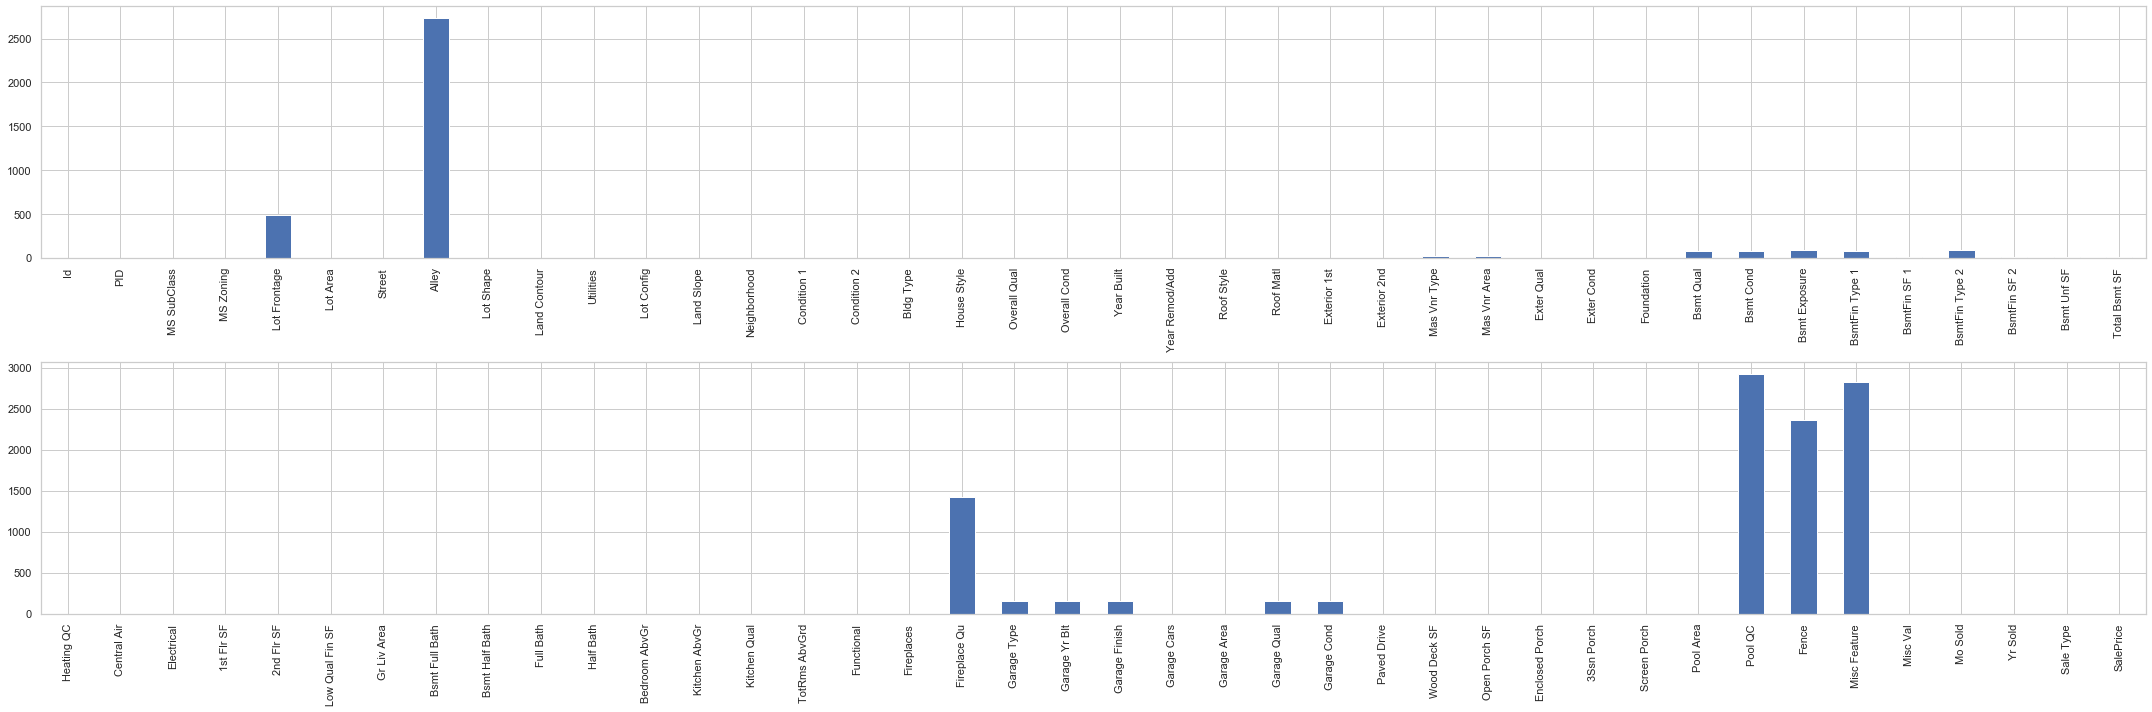

In [451]:
#Build your figure space
plt.figure(figsize=(30,10))

#We're dealing with a lot of features. Let's break out our 
#null visualization onto two separate subplots starting with the first ~half of the features.
plt.subplot(2,1,1)
houses.iloc[:,0:40].isnull().sum().plot(kind='bar')

#Now onto the rest of the features
plt.subplot(2,1,2)
houses.iloc[:,41:81].isnull().sum().plot(kind='bar')
plt.tight_layout()

In [452]:
#Build list of columns that contain any null features
any_null_cols = [i for i in houses.columns if houses[i].isnull().any()]
print(any_null_cols,end=' ')

['Lot Frontage', 'Alley', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Electrical', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence', 'Misc Feature'] 

Next, it will be helpful for us to build out a list of columns by their type. Specifically, I'm interested in building a list of nominal columns and ordinal columns as these are likely to require relabeling.

### Ordinals

We'll use the list we built to see what ordinal null values remain and at what volume. Because we've encoded, we are comfortable using the average for these features as a NaN imputation method.

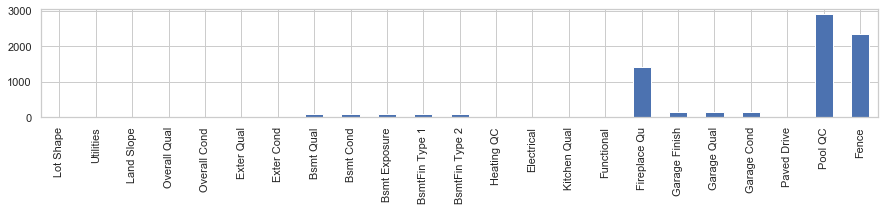

In [453]:
#Plot Ordinal Nulls
plt.figure(figsize=(15,2))
houses[ordinal_cols].isnull().sum().plot(kind='bar');


### Fireplace Qu, Pool QC, Fence

After encoding, these fields have quite a few NaNs that need to be addressed. Because the data dictionary for these three fields has an ordinal value 'None' that we translated into value '0', we'll apply value '0' everywhere we see NaNs. There is no other information from corresponding features that will allow us to make a more educated guess.

In [454]:
houses['Fireplace Qu'] = houses['Fireplace Qu'].fillna(0)
houses['Pool QC'] = houses['Pool QC'].fillna(0)
houses['Fence'] = houses['Fence'].fillna(0)

### Basements

Similar to Garage features, there are also a number of Basement features that take on NaN when there is not a Basement (when BsmntFin SF 1 is 0, for example). Because we have imputed our ordinals already for Basement features, we'll fill these values with zeroes to remain consistent with Basement SF metrics.

In [455]:
#Check Basement related features
houses.loc[(houses['Bsmt Exposure'].isnull()==True),
['Bsmt Exposure','Bsmt Qual','Bsmt Cond','BsmtFin Type 1','BsmtFin Type 2','BsmtFin SF 1']].head()

,Bsmt Exposure,Bsmt Qual,Bsmt Cond,BsmtFin Type 1,BsmtFin Type 2,BsmtFin SF 1
12,NaN,NaN,NaN,NaN,NaN,0.0
93,NaN,NaN,NaN,NaN,NaN,0.0
114,NaN,NaN,NaN,NaN,NaN,0.0
146,NaN,NaN,NaN,NaN,NaN,0.0
183,NaN,NaN,NaN,NaN,NaN,0.0


In [456]:
#For all basement NaNs, impute with the feature average
houses['Bsmt Qual'] = houses['Bsmt Qual'].fillna(0)
houses['Bsmt Cond'] = houses['Bsmt Cond'].fillna(0)
houses['Bsmt Exposure'] = houses['Bsmt Exposure'].fillna(0)
houses['BsmtFin Type 1'] = houses['BsmtFin Type 1'].fillna(0)
houses['BsmtFin Type 2'] = houses['BsmtFin Type 2'].fillna(0)
houses['BsmtFin SF 1'] = houses['BsmtFin SF 1'].fillna(0)
houses['BsmtFin SF 2'] = houses['BsmtFin SF 2'].fillna(0)

### Garages

Garage features are an interesting part of this data set. Let's look a little more closely at our null values across all features. While Garage Area / Garage Cars are numerical features that we can easily reference for our modeling, we notice that corresponding featuers have a number of NaNs. In disecting this further is becomes apparent that these NaNs occur when there is no garage (When Garage Area, or Garage Type, is 0). While we were initially interested in just the ordinal NaNs here, we'll apply 'NA' across the board where there is no Garage for these features (including Garage Yr Built, for example).

In [457]:
houses.loc[(houses['Garage Area'] == 0) | (houses['Garage Cars'] == 0),
          ['Garage Area', 'Garage Cars','Garage Type', 'Garage Yr Blt','Garage Finish', 'Garage Qual',
          'Garage Cond']].head()

,Garage Area,Garage Cars,Garage Type,Garage Yr Blt,Garage Finish,Garage Qual,Garage Cond
28,0.0,0.0,NaN,NaN,NaN,NaN,NaN
53,0.0,0.0,NaN,NaN,NaN,NaN,NaN
65,0.0,0.0,NaN,NaN,NaN,NaN,NaN
79,0.0,0.0,NaN,NaN,NaN,NaN,NaN
101,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [458]:
# In all cases where there isn't a garage, impute NaNs for corresponding Garage features to 'NA'
houses.loc[(houses['Garage Area'] == 0) | (houses['Garage Cars'] == 0),
          ['Garage Type', 'Garage Yr Blt','Garage Finish', 'Garage Qual',
          'Garage Cond']] = 0

While we're looking at Garage features, we'll also take a moment to impute NaNs. Let's see how many NaNs we're dealing with across this feature set.

In [459]:
#Find all columns related to Garages that have any nulls
houses[list(houses.filter(like='Garage', axis=1).columns)].isnull().sum()

Garage Type      0
Garage Yr Blt    2
Garage Finish    2
Garage Cars      1
Garage Area      1
Garage Qual      2
Garage Cond      2
dtype: int64

We're not dealing with a ton of NaNs here. Everything here is also nominal, so we'll fill with zero

In [460]:
houses['Garage Finish'] = houses['Garage Finish'].fillna(0)
houses['Garage Cars'] = houses['Garage Cars'].fillna(0)
houses['Garage Area'] = houses['Garage Area'].fillna(0)
houses['Garage Area'] = houses['Garage Area'].fillna(0)
houses['Garage Qual'] = houses['Garage Qual'].fillna(0)
houses['Garage Cond'] = houses['Garage Cond'].fillna(0)
houses['Garage Yr Blt'] = houses['Garage Yr Blt'].fillna(0)

### Electrical, Functional

We're not dealing with a ton of NaNs here. Everything here is also nominal, so we'll fill with the mean, similar to our approach above.

In [461]:
houses[['Electrical', 'Functional']].isnull().sum()

Electrical    1
Functional    2
dtype: int64

In [462]:
houses[['Electrical', 'Functional']]= houses[['Electrical', 'Functional']].fillna('None')

### Nominal Columns

There are also a number of nominal features in place for which we'll need to impute NaNs. Let's start with this data type first. We'll begin by building a list of nominal columns containing any NaNs and isolate those columns case by case to correct.

In [463]:
#Find all nominal columns with a NaN value
nominal_any_null_cols =[i for i in nominal_cols if i in any_null_cols]

In [464]:
#Isolate to nominal columns with NaN
houses[nominal_any_null_cols].columns

Index(['Alley', 'Mas Vnr Type', 'Garage Type', 'Misc Feature'], dtype='object')

#### Alley

Starting with the **Alley** feature, a quick count of values this column takes on shows a couple of things. First, that the only differentiation here is between gravel and paved alleyways. Second, that a very small number of home records contain Alley information. For this reason, we'll be comfortable simply converting this into a binary 1/0 Yes/No encoding for if an alley is present or not for a home.

In [465]:
#Check Alley Values
pd.DataFrame(houses['Alley'].value_counts())

,Alley
Grvl,120
Pave,78


In [466]:
#Adjust this field to be binary
houses.loc[houses['Alley'].notnull(),'Alley'] = 1
houses.loc[(houses['Alley'].isnull()), 'Alley'] = 0

#### Misc Feature

We'll now move onto the **Misc Feature** column and execute the same analysis. We notice a similar pattern here-- very few homes have a value for this section (~100 observation), and a very strong majority of these "Misc Features" are of type "Shed." For this reason, we'll adjust this column to reflect Sheds only.

In [467]:
#Check Misc Features
pd.DataFrame(houses['Misc Feature'].value_counts())

,Misc Feature
Shed,95
Gar2,5
Othr,4
TenC,1
Elev,1


In [468]:
#We're primarily looking at shed data, adjust field accordingly
houses.loc[(houses['Misc Feature'] == 'Shed'),'Misc Feature'] = 1
houses.loc[(houses['Misc Feature'] != 'Shed'),'Misc Feature'] = 0

#### Mas Vnr Type

Let's now turn our attention to 'Mas Vnr Type.' A quick glance at the data dictionary tells us this describes the type of exterior treatment of each home. In looking at the distribution of values, a **strong majority are of type 'None'** (1752 observations). For this reason, unless otherwise noted, I am comfortable using this same designation for null values (it will always be the case that a home has an exterior treatment, and if we have no further information, we should label these records as 'None.')

In [469]:
#Check Mas Vnr Type
pd.DataFrame(houses['Mas Vnr Type'].value_counts())

,Mas Vnr Type
None,1752
BrkFace,880
Stone,249
BrkCmn,25
CBlock,1


In [470]:
#Set to None if we have no data for Mas Vnr Type
houses['Mas Vnr Type'] = houses['Mas Vnr Type'].fillna('None')

In [471]:
houses['Mas Vnr Type'].isnull().sum()

0

### Discrete/Continous Features

We'll now move our attention to remaining null values, which should only be for discrete/continous data type columns. Let's re-visit our initial null value bar chart to confirm this.

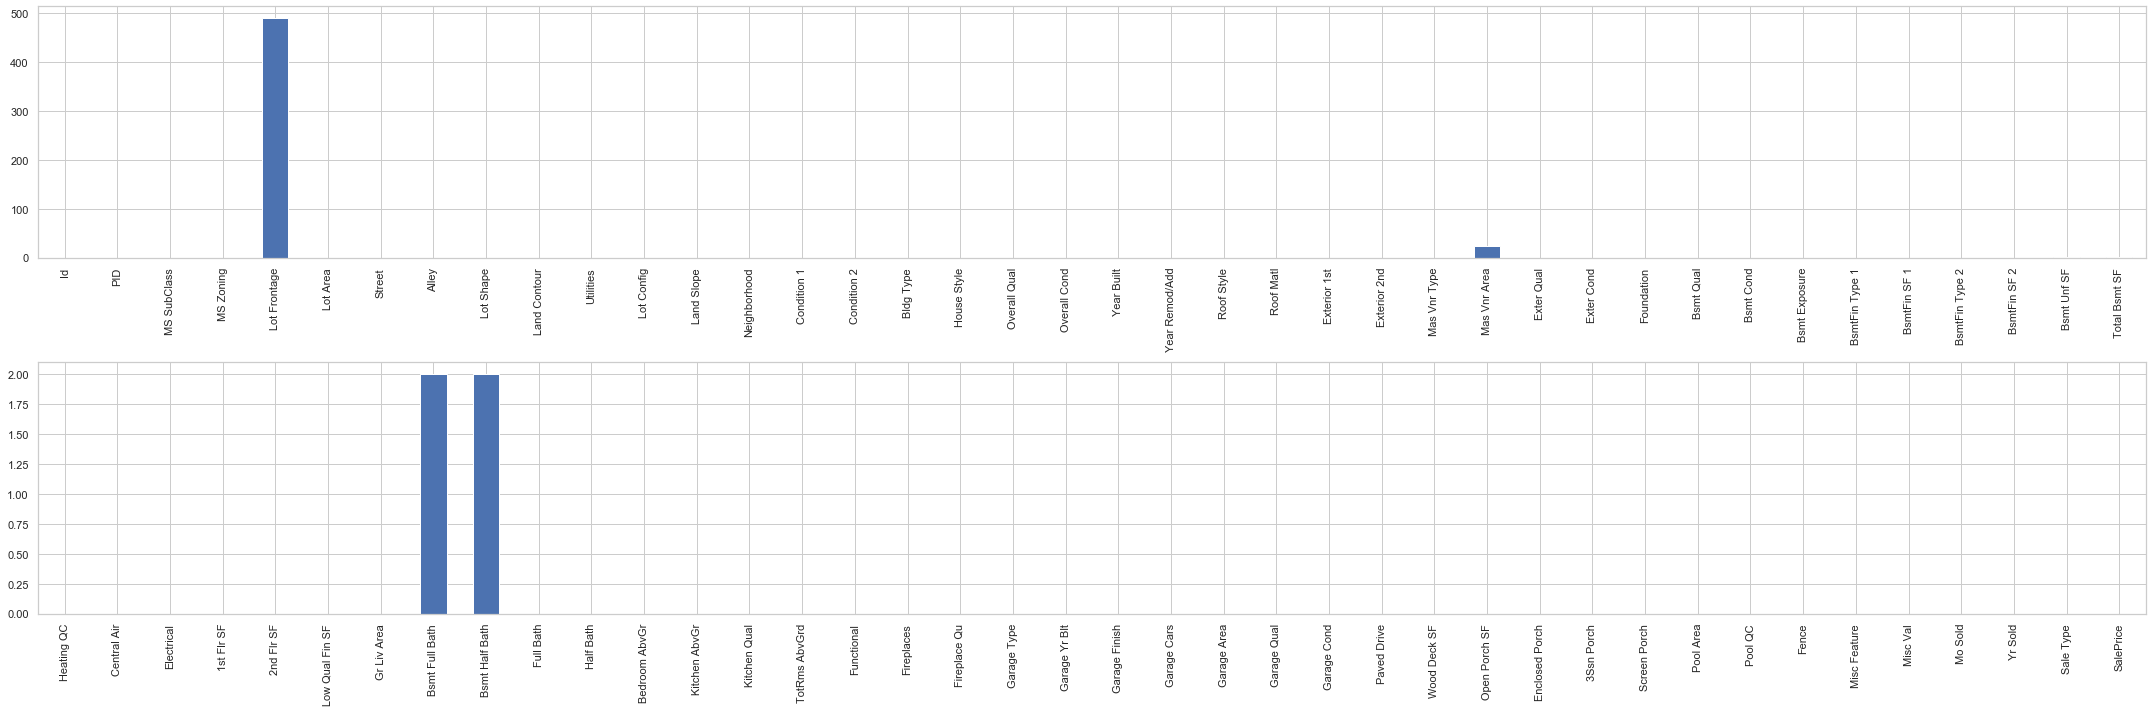

In [472]:
#Build your figure space
plt.figure(figsize=(30,10))

#We're dealing with a lot of features. Let's break out our 
#null visualization onto two separate subplots starting with the first ~half of the features.
plt.subplot(2,1,1)
houses.iloc[:,0:40].isnull().sum().plot(kind='bar')

#Now onto the rest of the features
plt.subplot(2,1,2)
houses.iloc[:,41:81].isnull().sum().plot(kind='bar')
plt.tight_layout()

### Lot Frontage

This feature has a large amount of NaN values. From our knowledge of the real estate market, the value it adds to a home may also be non negligible. So, while we've been leveraging means to impute our data for a majority of discrete/continouus features, here we may want to be more precise. One approach that could make sense is to leverage the Neighborhood averages, so we will take this approach.

In [473]:
#Find average lot frontage by neighborhood
hood_avg = houses.groupby('Neighborhood')['Lot Frontage'].mean()

#Drop neighborhood into the NaNs for Lot Frontage
houses['Lot Frontage'] = houses['Lot Frontage'].fillna(houses['Neighborhood'])

#Replace neighborhood with our averages
houses['Lot Frontage'] = houses['Lot Frontage'].map(lambda x: hood_avg[x] if type(x)==str else x)

In [474]:
#Fill in NaNs for Discrete/Continous with means
houses['Mas Vnr Area'] = houses['Mas Vnr Area'].fillna(0)
houses['Bsmt Unf SF'] = houses['Bsmt Unf SF'].fillna(0)
houses['Lot Frontage'] = houses['Lot Frontage'].fillna(np.mean(houses['Lot Frontage']))
houses['Bsmt Full Bath'] = houses['Bsmt Full Bath'].fillna(0)
houses['Bsmt Half Bath'] = houses['Bsmt Half Bath'].fillna(0)
houses['Total Bsmt SF'] = houses['Total Bsmt SF'].fillna(0)
houses['BsmtFin Type 1'] = houses['BsmtFin Type 1'].fillna(0)
houses['BsmtFin Type 2'] = houses['BsmtFin Type 2'].fillna(0)
houses['Garage Area'] = houses['Garage Area'].fillna(0)

## Build Dummies

Now, that we've dealt with our NaN values, we'll turn out attention to dummy creation. Building dummies is an essential part of the modeling process and allows us to create individual features for our features of type object. Each column will represent a feature group and whether or not this observation has a corresponding feature value through binary encoding. We can then feed these into our model. Of course, when we call get_dummies() we want to be careful that we drop the first feature value so as not to introduce multi-collinearity. This approach is called **one hot encoding.**

In [475]:
len(nominal_cols)

23

In [476]:
#Build your dummies out
dummy_df = pd.get_dummies(houses[nominal_cols], drop_first=True)

cols_for_merge = dummy_df.columns.difference(houses.columns)
dummy_df = dummy_df[cols_for_merge]

In [477]:
#How many dummies?
dummy_df.shape

(2930, 140)

In [478]:
#If features don't have a lot of sample, let's drop them.
dummy_df = dummy_df.drop([col for col, val in dummy_df.sum().iteritems() if val < 50], axis=1)

In [479]:
#How many dummies with reasonable sample?
dummy_df.shape

(2930, 69)

In [480]:
houses = pd.concat([houses,dummy_df], axis=1)

After dummy-encoding, dropping encoded dummies that don't meet a prescribed sample threshold, and merging together, we are left with the following dataset shape.

In [481]:
houses.shape

(2930, 150)

## Feature Creation

Before reading this out to .csv, we'll take some time to generate some new features for our dataset. Given our knowledge of the real estate market, it's very likely that total SF is going to be a reasonable predictor for price. As we are dealing with a number of Area/SF features, let's go ahead and combine them. In addition to this, we have two features for full and half bathrooms. Let's also combine these into one feature. Finally, the age of the home in question must figure into sales price. What could be interesting here, though, is building a feature that is representative of Age, not year built.

In [482]:
#Generate new feature for Total Area
houses['Total Area'] = houses['Gr Liv Area'] + houses['Garage Area'] + houses['Wood Deck SF'] + houses['Open Porch SF'] + houses['Total Bsmt SF']

In [483]:
#Generate new feature for total bathrooms
houses['Total Baths'] = houses['Full Bath'] + (0.5 * houses['Half Bath'])

In [484]:
#What is the most recent home
houses['Year Built'].max()

#Calculate home age
houses['Age'] = houses['Year Built'].max() - houses['Year Built']

In [485]:
## Build Dummies#finally, read this to a csv so we can reference in our EDA/model creation file
houses.to_csv('./datasets/houses_clean.csv')